# Projet 5 - Catégorisez automatiquement des questions

## Importation des librairies et des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
pd.options.mode.chained_assignment = None  # default='warn'
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk import *

In [2]:
test_df = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
train.head()

,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0


## Nettoyage des données

In [4]:
train_df = train.sample(frac = 0.5)

In [5]:
train_df['Body'] = train_df['Title'] + ' ' + train_df['Body']
test_df['Body'] = test_df['Title'] + ' ' + test_df['Body']

In [6]:
#train_df.drop(index = 57652, inplace = True)

In [7]:
train_df['processed_tags'] = train_df['Tags'].str.findall("<(.*?)>")
test_df['processed_tags'] = test_df['Tags'].str.findall("<(.*?)>")
train_df['Body'] = train_df['Body'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
test_df['Body'] = test_df['Body'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
train_df['Body'] = train_df['Body'].map(lambda x: x.replace('\n', ' '))
test_df['Body'] = test_df['Body'].map(lambda x: x.replace('\n', ' '))
train_df = train_df.drop(['Tags', 'Title'], axis = 1)
test_df = test_df.drop(['Tags', 'Title'], axis = 1)

### Définition des fonctions de nettoyage

In [8]:
def tokenization(sentence):
    token = RegexpTokenizer(r'[a-zA-Z]+')
    return token.tokenize(sentence.lower())

stop_words = set(stopwords.words('english'))
def clean_stopwords(sentence):
    return [word for word in sentence if not word in stop_words]

lemmatizer = WordNetLemmatizer()
def lemmatisation(sentence):
    return [lemmatizer.lemmatize(word) for word in sentence]

#### Exemple

In [9]:
example_sentence = 'Hello, this are 3 examples to show the different steps of the cleaning process.'

In [10]:
tok_sentence = tokenization(example_sentence)
clean_sentence = clean_stopwords(tok_sentence)
lemm_sentence = lemmatisation(clean_sentence)

In [11]:
print('Phrase originale: ', example_sentence, '\n')
print('Phrase tokenisée, en minuscules et sans ponctuation:', tok_sentence, '\n')
print('Phrase sans les stop words: ', clean_sentence, '\n')
print('Phrase lemmatisée: ', lemm_sentence)

Phrase originale:  Hello, this are 3 examples to show the different steps of the cleaning process. 

Phrase tokenisée, en minuscules et sans ponctuation: ['hello', 'this', 'are', 'examples', 'to', 'show', 'the', 'different', 'steps', 'of', 'the', 'cleaning', 'process'] 

Phrase sans les stop words:  ['hello', 'examples', 'show', 'different', 'steps', 'cleaning', 'process'] 

Phrase lemmatisée:  ['hello', 'example', 'show', 'different', 'step', 'cleaning', 'process']


#### Application sur le jeu de données

In [12]:
train_df['processed_body'] = train_df['Body'].map(lambda x: tokenization(x))
test_df['processed_body'] = test_df['Body'].map(lambda x: tokenization(x))
train_df['processed_body'] = train_df['processed_body'].map(lambda x: clean_stopwords(x))
test_df['processed_body'] = test_df['processed_body'].map(lambda x: clean_stopwords(x))
train_df['processed_body'] = train_df['processed_body'].map(lambda x: lemmatisation(x))
test_df['processed_body'] = test_df['processed_body'].map(lambda x: lemmatisation(x))
train_df['processed_body_2'] = train_df['processed_body'].map(lambda x: clean_stopwords(x))
test_df['processed_body_2'] = test_df['processed_body'].map(lambda x: clean_stopwords(x))

## Nettoyage des tags

### Suppression de tags 

In [13]:
tags_count = pd.Series([item for sublist in train_df['processed_tags'].tolist() for item in sublist]).value_counts()
n_top_tags = 20
tags_filter = train_df['processed_tags'].map(lambda x: any(elem in x for elem in tags_count[:n_top_tags].index.tolist()))
filtered_df = train_df[tags_filter]
filtered_df.shape

(69490, 10)

### Fréquence des tags

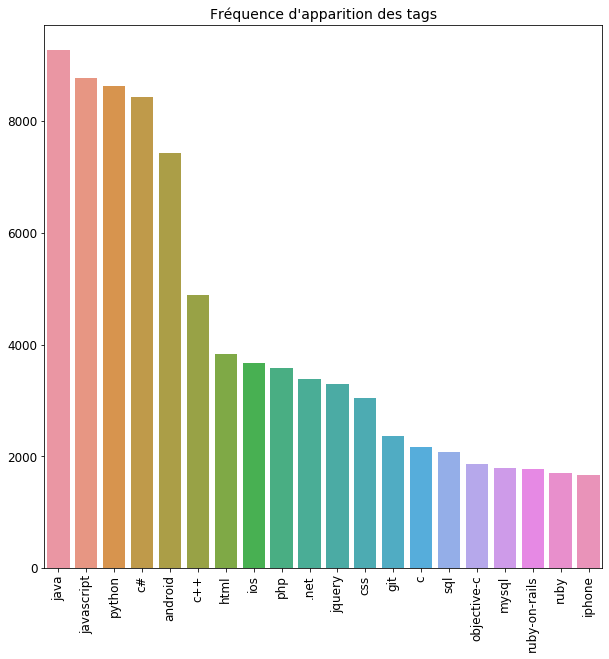

In [14]:
plt.figure(figsize=(10,10))
sns.barplot(x = tags_count[:20].index , y = tags_count[:20])
plt.title('Fréquence d\'apparition des tags', fontsize = 14)
plt.xticks(label = 'Tags', rotation = 90, fontsize = 12)
plt.yticks(label = 'Nombre d\'apparition', fontsize = 12);

## Fréquence des termes

In [15]:
body_list = train_df['processed_body'].tolist()

In [16]:
fw_counts = Counter([elt for lst in body_list for elt in lst])
fw_common_words = [word[0] for word in fw_counts.most_common(25)]
fw_common_counts = [word[1] for word in fw_counts.most_common(25)]

In [17]:
fw_words_total = [word[0] for word in fw_counts.most_common()]
fw_counts_total = [word[1] for word in fw_counts.most_common()]

In [18]:
fw_counts_number = pd.Series(fw_counts_total)

In [19]:
len(fw_counts_number)

184509

In [20]:
limite = 500
print('Limite fixée: ', limite)

Limite fixée:  500


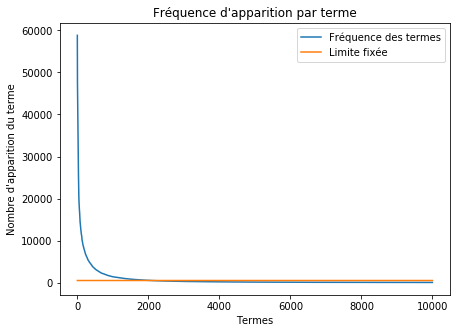

In [21]:
plt.figure(figsize=(7,5))
plt.plot(range(10000), fw_counts_number.iloc[0:10000], label='Fréquence des termes')
plt.plot(range(10000), [limite]*10000, label = 'Limite fixée')
plt.xlabel('Termes')
plt.ylabel('Nombre d\'apparition du terme')
plt.title('Fréquence d\'apparition par terme')
plt.legend();

### Suppressions des termes les moins fréquents

In [22]:
stop_words = set(stopwords.words('english'))

fw_dict = dict(fw_counts)

In [23]:
fw_dict = dict(fw_counts)
del_words = []
for key, value in fw_dict.items():
    if value <= limite:
        stop_words.add(key) #ajouts des mots à la liste de stopwords
        del_words.append(key)
[fw_dict.pop(key) for key in del_words]

[18,
 145,
 3,
 65,
 301,
 206,
 44,
 39,
 40,
 227,
 169,
 17,
 319,
 99,
 420,
 10,
 15,
 115,
 469,
 334,
 32,
 158,
 78,
 475,
 1,
 1,
 425,
 493,
 394,
 82,
 242,
 17,
 5,
 11,
 158,
 83,
 60,
 274,
 489,
 27,
 33,
 333,
 36,
 96,
 465,
 33,
 1,
 10,
 4,
 394,
 1,
 130,
 74,
 49,
 232,
 68,
 130,
 224,
 328,
 198,
 380,
 116,
 356,
 154,
 88,
 280,
 139,
 167,
 202,
 210,
 36,
 259,
 223,
 375,
 371,
 1,
 2,
 451,
 202,
 179,
 110,
 223,
 47,
 212,
 41,
 35,
 278,
 422,
 1,
 357,
 159,
 161,
 98,
 32,
 18,
 153,
 1,
 1,
 6,
 229,
 326,
 98,
 160,
 303,
 436,
 163,
 57,
 8,
 14,
 3,
 407,
 1,
 1,
 1,
 165,
 4,
 490,
 478,
 397,
 375,
 101,
 107,
 23,
 93,
 158,
 10,
 104,
 2,
 68,
 261,
 1,
 88,
 7,
 9,
 10,
 185,
 1,
 10,
 1,
 5,
 48,
 78,
 330,
 367,
 1,
 1,
 2,
 342,
 17,
 95,
 5,
 1,
 1,
 1,
 9,
 1,
 392,
 17,
 62,
 241,
 7,
 51,
 173,
 156,
 339,
 399,
 158,
 356,
 194,
 64,
 153,
 1,
 15,
 14,
 64,
 44,
 98,
 329,
 387,
 2,
 103,
 228,
 413,
 155,
 152,
 89,
 30,
 455,
 173,


In [24]:
sorted(fw_dict.items(), key=lambda t: t[0])

[('ab', 838),
 ('abc', 1418),
 ('ability', 527),
 ('able', 7552),
 ('absolute', 1005),
 ('abstract', 1306),
 ('accept', 1612),
 ('accepted', 712),
 ('access', 8333),
 ('accessing', 723),
 ('accomplish', 908),
 ('according', 1656),
 ('account', 2812),
 ('achieve', 2181),
 ('across', 1909),
 ('act', 538),
 ('action', 6744),
 ('actionbar', 597),
 ('active', 2260),
 ('activerecord', 740),
 ('activity', 5551),
 ('activitythread', 2204),
 ('actual', 2022),
 ('actually', 4171),
 ('ad', 1121),
 ('adapter', 1159),
 ('adb', 590),
 ('add', 17894),
 ('added', 4323),
 ('adding', 3352),
 ('addition', 629),
 ('additional', 1385),
 ('address', 4670),
 ('admin', 2092),
 ('advance', 2069),
 ('advantage', 1122),
 ('advice', 853),
 ('aes', 665),
 ('affect', 552),
 ('age', 1474),
 ('agent', 853),
 ('ago', 791),
 ('ajax', 2856),
 ('alert', 2620),
 ('algorithm', 2166),
 ('alias', 879),
 ('align', 1306),
 ('alloc', 1070),
 ('allow', 3019),
 ('allowed', 1343),
 ('allows', 1311),
 ('almost', 994),
 ('along', 11

In [25]:
len(fw_dict)

2088

### Word cloud

In [26]:
wordcloud = WordCloud(stopwords=stop_words).generate_from_frequencies(fw_counts)

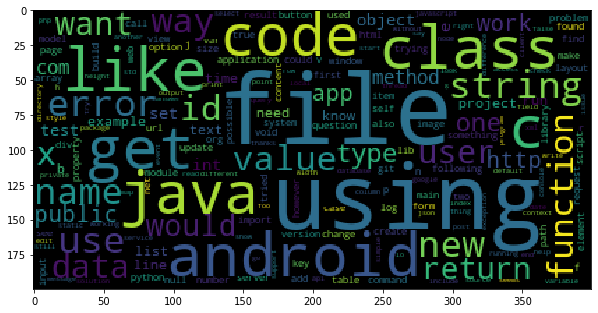

In [27]:
plt.figure(figsize = (10,9))
plt.imshow(wordcloud);

## Tf-idf

### CountVectorizer

In [28]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        token = RegexpTokenizer(r'[a-zA-Z]+')
        return [self.wnl.lemmatize(t) for t in token.tokenize(doc.lower()) if t not in stop_words]
wnl = WordNetLemmatizer()    
tokenizer = lambda x: [wnl.lemmatize(x) for x in token.tokenize(x.lower()) if x not in stop_words]
    
    
count = CountVectorizer(tokenizer=LemmaTokenizer(),
                        stop_words=stop_words, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [29]:
pipe.fit(train_df["Body"])

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words={'a', 'aa', 'aaa', 'aaaa', 'aaaaa',
                                             'aaaaaa', 'aaaaaaa', 'aaaaaaaa',
                                             'aaaaaaaaa', 'aa...
                                             'aaaaaaaaaaaaaaaaaadwpwaaaaaaaabaaaaaaaaaceaaaaaaaaaqqaaaaaaaabraaaaaaaaageaaaaaaaaacqaaaaaaaacbaaaaaaaaaikaaaaaaaaakqaaaaaaaaczaaaaaaaaakeaaaaaaaaaqqaaaaaaaacxaaaaaaaaalkaaaaaaaaawqaaaaaaaadfaaaaaaaaamkaaaaaaaaazqaaaaaaaadraaaaaaaaanuaaaaaaaaa', ...},
         

In [30]:
train_feature = pipe.transform(train_df["Body"])
train_feature

<102216x2082 sparse matrix of type '<class 'numpy.float64'>'
	with 3584572 stored elements in Compressed Sparse Row format>

In [31]:
feature_names_train = count.get_feature_names()

In [32]:
len(feature_names_train)

2082

In [33]:
test_feature = pipe.transform(test_df["Body"])
feature_names_test = count.get_feature_names()
len(feature_names_test)

2082

In [34]:
dense_train = train_feature.todense()
denselist_train = dense_train.tolist()
train_mx = pd.DataFrame(denselist_train, columns= feature_names_train)

In [35]:
dense_test = test_feature.todense()
denselist_test = dense_test.tolist()
test_mx = pd.DataFrame(denselist_test, columns= feature_names_test)

## Exportation des données

In [36]:
test_mx.to_csv('test_mx.csv', sep=';')
train_mx.to_csv('train_mx.csv', sep=';')